### Importing all the required dependecies

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

from torch.utils.data import DataLoader
from BPSDataLoader import load_torch_data
from Model import DoseRadNet
from config import (
    BATCH_SIZE,
    LR,
    ADAM_B2,
    ADAM_B1,
    EPOCHS,
    N_COLS,
    N_ROWS,
)
from utils import get_data_and_count, restructure_time_data_dict, visualize_gradcam

### Checking GPU availability

In [ ]:

device = "mps" if torch.backends.mps.is_available() else "cpu" # for Apple M1
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for all other GPUs
print(f"Using device: {device}")


### Load the data and labels

In [ ]:
data_paths, time_data_paths = get_data_and_count()
time_data_dict = restructure_time_data_dict(time_data_paths)
time_period = 24 # change according to the time you are considering. Can be 4,24,48.
train_data, val_data, test_data = load_torch_data(time_data_dict[time_period]) # splits the data into train, test and validation

### Wrapper function to process the output from model and passing it to Captum's visualization method

In [ ]:
def visualize_gradcam(attr, img, batch_idx, rad_labels, rad_pred):
    """
    Visualization of the gradcam on input data
    :param attr: Grad cam attributes
    :param img: Input image
    :param batch_idx: Batch number - used to label the result image
    :param labels: Ground truth of the image
    :param pred_labels: Prediction label for the image
    :return: None
    """
    attr = np.transpose(attr.squeeze().cpu().detach().numpy(), (1, 2, 0))
    img = np.transpose(img.squeeze().cpu().detach().numpy(), (1, 2, 0))
    plt.style.use('grayscale')
    for idx in range(img.shape[2]):
        attr_slice = attr[:, :, idx].reshape(attr.shape[0], attr.shape[1], 1)
        img_slice = img[:, :, idx].reshape(img.shape[0], img.shape[1], 1)
        vis_types = ["original_image", "blended_heat_map"]
        vis_signs = ["all", "positive"]
        #visualization method from Captum
        fig, _ = viz.visualize_image_attr_multiple(
            attr_slice,
            img_slice,
            vis_types,
            vis_signs,
            ["Input image", "GradCam"],
            show_colorbar=True,
            use_pyplot=True # set to false if you prefer not to view the output on the run
        )
        plt.style.use('grayscale')
        
"""Uncommment the following to save all the gradcam output to a directory named 'grad_cam'. """

#         fig.savefig(
#             f'./grad_cam/gradcam_{batch_idx}_{idx}_rad{rad_labels[idx].item()}_p-rad'
#             f'{rad_pred[idx].item()}.png'
#         )


### Testing the model with pretrained weights and visualizing the GradCAM output from the last convolution layer of the model

In [ ]:
model_params = {}
cnn = DoseRadNet() # Loading the model architecture
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, betas=(ADAM_B1, ADAM_B2)) # Defining optimizer

test_loader = DataLoader(test_data, batch_size=2) # loading the test data into batches. 
                                                #Used batch size of 2, for the purpose of this demo

cnn.to(device) # moving the model to GPU.
cnn.load_state_dict(torch.load('./checkpoint.pt')) # loading the saved weights to the model.

def gradcam_wrapper(inp):
"""    
    Warpper function to make captum work with the two branch CNN.
    Note: This function is not required if you are using a normal CNN.
    :param inp: Input to the CNN
    :return: Returns the radiation output from the forward() method of the two branch CNN model.
"""
    return cnn(inp)[1]


gradcam = LayerGradCam(gradcam_wrapper, cnn.conv2)

with torch.no_grad():
    for idx, data in enumerate(test_loader):
        images, rad_labels = data[0].to(device), data[1].to(device)
        rad_output,_ = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(rad_output.data, 1)
        _, act_label = torch.max(rad_labels.data, 1)

        attribution = gradcam.attribute(images, target=act_label)
        upsampled_attr = LayerAttribution.interpolate(attribution, (N_ROWS, N_COLS))
        visualize_gradcam(upsampled_attr, images, idx, act_label, predicted)

        if idx == 0: # Delete this step. Added for the purpose of demo.
            break

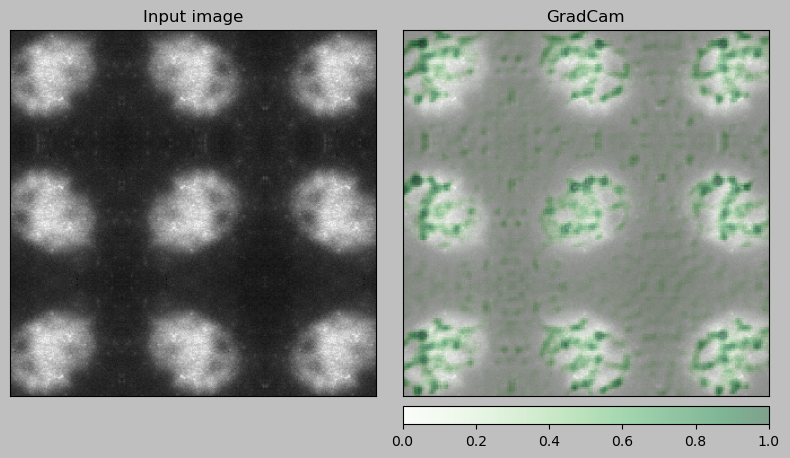

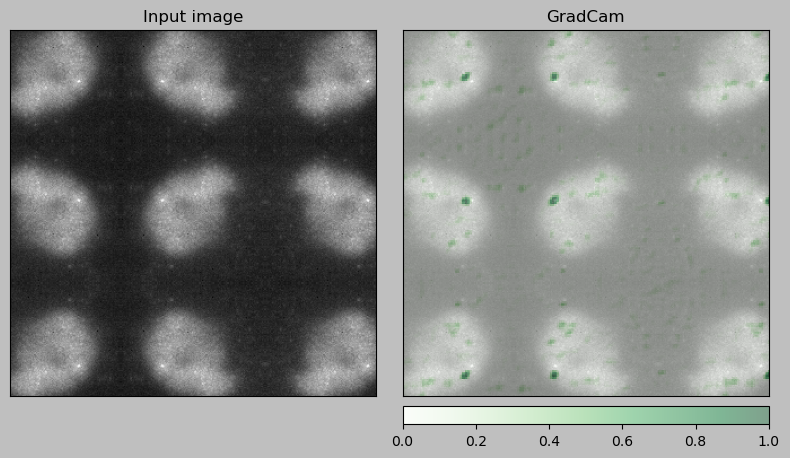

In [24]:
model_params = {}
cnn = DoseRadNet() # Loading the model architecture
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, betas=(ADAM_B1, ADAM_B2)) # Defining optimizer

test_loader = DataLoader(test_data, batch_size=2) # loading the test data into batches. 
                                                #Used batch size of 2, for the purpose of this demo

cnn.to(device) # moving the model to GPU.
cnn.load_state_dict(torch.load('./checkpoint.pt')) # loading the saved weights to the model.

def gradcam_wrapper(inp):
"""    
    Warpper function to make captum work with the two branch CNN.
    Note: This function is not required if you are using a normal CNN.
    :param inp: Input to the CNN
    :return: Returns the radiation output from the forward() method of the two branch CNN model.
"""
    return cnn(inp)[1]


gradcam = LayerGradCam(gradcam_wrapper, cnn.conv2)

with torch.no_grad():
    for idx, data in enumerate(test_loader):
        images, rad_labels = data[0].to(device), data[1].to(device)
        rad_output,_ = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(rad_output.data, 1)
        _, act_label = torch.max(rad_labels.data, 1)

        attribution = gradcam.attribute(images, target=act_label)
        upsampled_attr = LayerAttribution.interpolate(attribution, (N_ROWS, N_COLS))
        visualize_gradcam(upsampled_attr, images, idx, act_label, predicted)

        if idx == 0: # Delete this step. Added for the purpose of demo.
            break